# Modeling for Feature Selection

This workbook will use Lasso to predict the value a house most accurately and most importantly, narrow down which features are the most important and have the most impact on the value they add to a house. 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import mean_squared_error, median_absolute_error
import os
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer

In [3]:
# use absolute path to retrieve datasets

train = pd.read_csv(os.path.abspath('./datasets/cleaned_train.csv'))
# sample = pd.read_csv(os.path.abspath('./datasets/sample_sub_reg.csv'))

[source for absolute path](https://stackoverflow.com/questions/51520/how-to-get-an-absolute-file-path-in-python)

In [4]:
# making a list of features whose distributions or saleprice differences 
# are not useful for unregularized model which I will drop

drop_lst = []
drop_lst.extend(['pool_area',  #not applicable to most homes
                'enclosed_porch',
                '3ssn_porch',
                'screen_porch',
                'garage_yr_blt',
                'bsmt_half_bath',
                'functional',
               'low_qual_fin_sf',
                'garage_qual',
                'paved_drive', 
                'central_air',
                'bsmtfin_sf_2',
                'kitchen_abvgr',
               'utilities',
               'land_slope', 
               'lot_area',
               'street',
               'land_slope', 
                'yr_sold',
                'bsmtfin_type_2',
                 'bsmtfin_sf_2',
                'exterior_2nd',
                'heating',
                'electrical',
                 'condition_1', 
                 'condition_2']) 



In [5]:
train.head()

,id,ms_subclass,ms_zoning,lot_frontage,lot_area,street,lot_shape,land_contour,utilities,lot_config,...,total_baths,bsmt_finished,size_n_qual,bed_n_bath,fin_bsmt_fin_qual,bsmt_fin_n_ceiling,bsmt_finished_with_bath,bsmt_finished_with_halfbath,bsmt_size_fin_sf,overall_qual_cond
0,109,60,RL,77.504886,13517,2,3,4,4,CulDSac,...,3.0,533.0,8874,9.0,2665.0,533.0,0.0,0.0,386425.0,48
1,544,60,RL,43.000000,11492,2,3,4,4,CulDSac,...,4.0,637.0,14854,16.0,3185.0,1274.0,637.0,0.0,581581.0,35
2,153,20,RL,68.000000,7922,2,4,4,4,Inside,...,2.0,731.0,5285,6.0,3655.0,731.0,731.0,0.0,772667.0,35
3,318,60,RL,73.000000,9802,2,4,4,4,Inside,...,3.0,0.0,7220,9.0,0.0,0.0,0.0,0.0,0.0,25
4,255,50,RL,82.000000,14235,2,3,4,4,Inside,...,2.0,0.0,8670,6.0,0.0,0.0,0.0,0.0,0.0,48


In [6]:
train.columns

Index(['id', 'ms_subclass', 'ms_zoning', 'lot_frontage', 'lot_area', 'street',
       'lot_shape', 'land_contour', 'utilities', 'lot_config', 'land_slope',
       'neighborhood', 'condition_1', 'condition_2', 'bldg_type',
       'house_style', 'overall_qual', 'overall_cond', 'year_built',
       'year_remod/add', 'roof_style', 'roof_matl', 'exterior_1st',
       'exterior_2nd', 'mas_vnr_type', 'mas_vnr_area', 'exter_qual',
       'foundation', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure',
       'bsmtfin_type_1', 'bsmtfin_sf_1', 'bsmtfin_type_2', 'bsmtfin_sf_2',
       'bsmt_unf_sf', 'total_bsmt_sf', 'heating', 'heating_qc', 'central_air',
       'electrical', '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf',
       'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath', 'full_bath',
       'half_bath', 'bedroom_abvgr', 'kitchen_abvgr', 'kitchen_qual',
       'totrms_abvgrd', 'functional', 'fireplaces', 'fireplace_qu',
       'garage_type', 'garage_yr_blt', 'garage_finish', 'garage_cars',
       

# Getting Dummys

In [7]:
neighborhood_dummys_train = pd.get_dummies(train[
    'neighborhood'], prefix = 'nh')

ms_subclass_dummys_train = pd.get_dummies(train[
    'ms_subclass'], prefix = 'subclass')

garage_type_dummys_train = pd.get_dummies(train[
    'garage_type'], prefix = 'garage_type')

In [8]:
neighborhood_dummys_train.head()

,nh_Blmngtn,nh_Blueste,nh_BrDale,nh_BrkSide,nh_ClearCr,nh_CollgCr,nh_Crawfor,nh_Edwards,nh_Gilbert,nh_Greens,...,nh_NoRidge,nh_NridgHt,nh_OldTown,nh_SWISU,nh_Sawyer,nh_SawyerW,nh_Somerst,nh_StoneBr,nh_Timber,nh_Veenker
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [9]:
ms_subclass_dummys_train.head()

,subclass_20,subclass_30,subclass_40,subclass_45,subclass_50,subclass_60,subclass_70,subclass_75,subclass_80,subclass_85,subclass_90,subclass_120,subclass_150,subclass_160,subclass_180,subclass_190
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


# Baseline

In [10]:
train['saleprice'].shape

(2049,)

In [11]:
baseline = train['saleprice'].mean()
baseline_list = [baseline for i in range(2049)]

In [12]:
baseline_score = r2_score(train['saleprice'], baseline_list)
baseline_score

0.0

# Prepping for the model

In [13]:
train.columns

Index(['id', 'ms_subclass', 'ms_zoning', 'lot_frontage', 'lot_area', 'street',
       'lot_shape', 'land_contour', 'utilities', 'lot_config', 'land_slope',
       'neighborhood', 'condition_1', 'condition_2', 'bldg_type',
       'house_style', 'overall_qual', 'overall_cond', 'year_built',
       'year_remod/add', 'roof_style', 'roof_matl', 'exterior_1st',
       'exterior_2nd', 'mas_vnr_type', 'mas_vnr_area', 'exter_qual',
       'foundation', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure',
       'bsmtfin_type_1', 'bsmtfin_sf_1', 'bsmtfin_type_2', 'bsmtfin_sf_2',
       'bsmt_unf_sf', 'total_bsmt_sf', 'heating', 'heating_qc', 'central_air',
       'electrical', '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf',
       'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath', 'full_bath',
       'half_bath', 'bedroom_abvgr', 'kitchen_abvgr', 'kitchen_qual',
       'totrms_abvgrd', 'functional', 'fireplaces', 'fireplace_qu',
       'garage_type', 'garage_yr_blt', 'garage_finish', 'garage_cars',
       

In [14]:
# making list of training feature names

features = [c for c in
            train._get_numeric_data().columns if 
            (c != 'saleprice') & (c != 'id')]

In [15]:
neighborhood_dummys_train.columns

Index(['nh_Blmngtn', 'nh_Blueste', 'nh_BrDale', 'nh_BrkSide', 'nh_ClearCr',
       'nh_CollgCr', 'nh_Crawfor', 'nh_Edwards', 'nh_Gilbert', 'nh_Greens',
       'nh_GrnHill', 'nh_IDOTRR', 'nh_Landmrk', 'nh_MeadowV', 'nh_Mitchel',
       'nh_NAmes', 'nh_NPkVill', 'nh_NWAmes', 'nh_NoRidge', 'nh_NridgHt',
       'nh_OldTown', 'nh_SWISU', 'nh_Sawyer', 'nh_SawyerW', 'nh_Somerst',
       'nh_StoneBr', 'nh_Timber', 'nh_Veenker'],
      dtype='object')

In [16]:
# making X and y with neighborhood dummys

X = train[features].join(neighborhood_dummys_train).drop('nh_Landmrk',
                                                         axis = 1)
X = X.join(ms_subclass_dummys_train).drop('subclass_150', 
                                         axis = 1)
X = X.join(garage_type_dummys_train).drop('garage_type_0', 
                                         axis = 1)
y = train['saleprice']

In [17]:
X.head()

,ms_subclass,lot_frontage,lot_area,street,lot_shape,land_contour,utilities,land_slope,overall_qual,overall_cond,...,subclass_120,subclass_160,subclass_180,subclass_190,garage_type_2Types,garage_type_Attchd,garage_type_Basment,garage_type_BuiltIn,garage_type_CarPort,garage_type_Detchd
0,60,77.504886,13517,2,3,4,4,3,6,8,...,0,0,0,0,0,1,0,0,0,0
1,60,43.000000,11492,2,3,4,4,3,7,5,...,0,0,0,0,0,1,0,0,0,0
2,20,68.000000,7922,2,4,4,4,3,5,7,...,0,0,0,0,0,0,0,0,0,1
3,60,73.000000,9802,2,4,4,4,3,5,5,...,0,0,0,0,0,0,0,1,0,0
4,50,82.000000,14235,2,3,4,4,3,6,8,...,0,0,0,0,0,0,0,0,0,1


## Train Test Split

In [18]:
# finding missing columns in test vs train data
def find_missing_test_columns(train, test):
    return [col for col in train.columns if col not in test.columns]

In [19]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [20]:
find_missing_test_columns(X_train, X_test)

[]

## Scaling

In [21]:
# scaling data before fitting

ss = StandardScaler()
ss.fit(X_train)
X_train_sc = ss.transform(X_train)  #or in same line - fit_transform
X_test_sc = ss.transform(X_test)

In [22]:
# power trainsformer for test and train
# pt = PowerTransformer()
# pt.fit(X_train)
# X_train = pt.transform(X_train)
# X_test = pt.transform(X_test)

In [23]:
pt_y = PowerTransformer()
# PowerTransformer requires a matrix/DataFrame, which is why we're using the .to_frame() method on y_train
pt_y.fit(y_train.to_frame()) 
y_train_pt = pt_y.transform(y_train.to_frame())
y_test_pt = pt_y.transform(y_test.to_frame())

# Instantiate Models

In [24]:
# lr = LinearRegression(n_jobs = -1)
lasso = LassoCV(n_jobs = -1, )

## Cross Validation

In [25]:
# over/underfitting?

cross_val_score(lasso, X_train_sc, y_train_pt, cv = 5)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

array([0.93247479, 0.92449861, 0.89598252, 0.93217258, 0.91761113])

In [26]:
baseline_previous = ('with  bsmt and gar cols dropped',
                     0.93103748,
                     0.92303652, 
                     0.89483461,
                     0.9304822 ,
                     0.91655483)

In [27]:
lasso_scores = cross_val_score(lasso, X_train_sc, y_train_pt, cv=3)
lasso_scores.mean()

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.9178725250998897

# Model Fitting and Evaluation

In [28]:
lasso_model = lasso.fit(X_train_sc, y_train_pt)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [29]:
lasso_score = lasso_model.score(X_train_sc, y_train_pt)
print(f'Lasso Train: {lasso_score}')

Lasso Train: 0.9311238306462134


In [30]:
lasso_test_score = lasso_model.score(X_test_sc, y_test_pt)
print(f'Lasso Test: {lasso_test_score}')

Lasso Test: 0.9057520759180662


In [31]:
lasso_pred = lasso_model.predict(X_test_sc)

In [32]:
# reversing power transformer on y
pred_unpower = pt_y.inverse_transform(lasso_pred.reshape(-1,1))

In [33]:
pred_unpower.shape

(513, 1)

In [34]:
pred_unpower

array([[129181.07696527],
       [378547.86018305],
       [104976.40220711],
       [129657.69431239],
       [126448.71790333],
       [301160.99138217],
       [206735.02292465],
       [175964.32694904],
       [254901.13891705],
       [143029.82231304],
       [192052.22890375],
       [277818.79378296],
       [111312.84900587],
       [121011.04665974],
       [239835.98284898],
       [100125.19000703],
       [220741.39609415],
       [202232.57785534],
       [128971.82920327],
       [235552.0745709 ],
       [152560.42689013],
       [104134.79033493],
       [118497.33978905],
       [215727.44366995],
       [123676.11649902],
       [161228.31186251],
       [104022.1737477 ],
       [182509.05263406],
       [210468.77905598],
       [129802.18092091],
       [128376.98820815],
       [223604.81483847],
       [136782.7587529 ],
       [222433.81107486],
       [124112.13863307],
       [260467.53246036],
       [203371.89405565],
       [142028.58041801],
       [1285

In [35]:
r2_score(y_test, pred_unpower)

0.935214950069317

# Metrics

In [36]:
def many_metrics(y_true, y_pred): # where p is # features used
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print('Mean squared error:          =', mse)
    print('Root mean squared error:     =', rmse)
    print('Mean absolute error:         =', mae)
    print('Median absolute error:       =', medae)
    print('R^2:                         =', r2)

[source](https://git.generalassemb.ly/DSIR-412/breakfast-hour/blob/master/lab-reviews/03-linear-regression-labs/Lab_Review_Week_3_FILLED.ipynb)

In [37]:
many_metrics(y_test, pred_unpower)

Mean squared error:          = 409578507.5522978
Root mean squared error:     = 20238.04604086812
Mean absolute error:         = 13857.61900408932
Median absolute error:       = 9889.55457717256
R^2:                         = 0.935214950069317


# Interpretation
The low distribution among cross val, test and training scores tells me the model is performing well, above baseline, and it neither overfit nor underfit. 

The model itself can account for 94% of variation in the housing prices given the features provided to it. 

# Plotting Model and Residuals

In [38]:
lasso_residuals = y_test - pred_unpower[0]

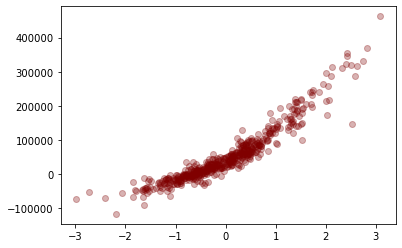

In [39]:
plt.scatter(lasso_pred, lasso_residuals, 
           c = 'maroon', alpha = .3);

(array([  7., 123., 197.,  99.,  43.,  25.,   7.,   9.,   2.,   1.]),
 array([-116392.07696527,  -58512.27696527,    -632.47696527,
          57247.32303473,  115127.12303473,  173006.92303473,
         230886.72303473,  288766.52303473,  346646.32303473,
         404526.12303473,  462405.92303473]),
 <BarContainer object of 10 artists>)

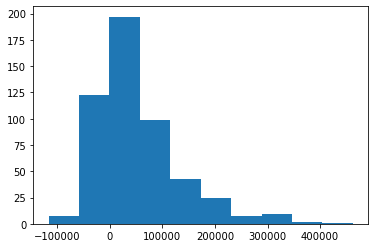

In [40]:
plt.hist(lasso_residuals)

**Interpretation**

We can see that there are some outliers that the model cannot account for using only the features given. This could be due to the fact that there are outliers in the total square feet, deck, and lot sizes.

# Coefficients and Intercept

In [41]:
lasso_coef = lasso_model.coef_

In [42]:
coef_df = pd.DataFrame({'feature': X.columns,
              'coef' : lasso_model.coef_})

coef_df[coef_df['coef'] == 0]
# coef_df['unitized'] = coef_df['coef'] * 

,feature,coef
4,lot_shape,0.0
5,land_contour,-0.0
6,utilities,0.0
7,land_slope,-0.0
15,bsmt_cond,0.0
19,bsmtfin_type_2,-0.0
21,bsmt_unf_sf,0.0
26,2nd_flr_sf,0.0
27,low_qual_fin_sf,-0.0
29,bsmt_full_bath,0.0


In [43]:
coef_df[(coef_df['coef'] > 0.005) | 
        (coef_df['coef'] < -.005)].sort_values('coef')


,feature,coef
72,nh_IDOTRR,-0.029314
100,subclass_160,-0.027209
73,nh_MeadowV,-0.024939
80,nh_OldTown,-0.024318
34,kitchen_abvgr,-0.022830
89,subclass_30,-0.020041
99,subclass_120,-0.011190
77,nh_NWAmes,-0.011037
83,nh_SawyerW,-0.010920
68,nh_Edwards,-0.010252


**Interpretation**
After selecting the best features which impact the home value the most, Lasso has show us that size, quality and age are leaed to the largest increase per respective unit in the home's value (in dollars).

In [44]:
best_features = coef_df[(coef_df['coef'] > 0.05) | 
        (coef_df['coef'] < -.05)].sort_values('coef')['feature']

In [45]:
best_features = list(best_features)
best_features

['lot_area',
 'overall_cond',
 'bsmt_fin_n_ceiling',
 'functional',
 'total_bsmt_sf',
 'year_built',
 'overall_qual',
 'gr_liv_area']

# Test Data: Prep and Scale

In [46]:
test = pd.read_csv('./datasets/cleaned_test.csv')

In [47]:
test['ms_subclass'].value_counts()

20     309
60     180
50      89
120     60
160     41
70      38
30      38
90      34
80      32
85      20
190     15
75       7
45       7
180      6
40       2
Name: ms_subclass, dtype: int64

In [48]:
#test dummies
neighborhood_dummys_test = pd.get_dummies(test[
    'neighborhood'], prefix = 'nh')

ms_subclass_dummys_test = pd.get_dummies(test[
    'ms_subclass'], prefix = 'subclass')

garage_type_dummys_test = pd.get_dummies(test[
    'garage_type'], prefix = 'garage_type')

#train dummies
neighborhood_dummys_train = pd.get_dummies(train[
    'neighborhood'], prefix = 'nh')

ms_subclass_dummys_train = pd.get_dummies(train[
    'ms_subclass'], prefix = 'subclass')

garage_type_dummys_train = pd.get_dummies(train[
    'garage_type'], prefix = 'garage_type')

In [49]:
ms_subclass_dummys_train.columns

Index(['subclass_20', 'subclass_30', 'subclass_40', 'subclass_45',
       'subclass_50', 'subclass_60', 'subclass_70', 'subclass_75',
       'subclass_80', 'subclass_85', 'subclass_90', 'subclass_120',
       'subclass_150', 'subclass_160', 'subclass_180', 'subclass_190'],
      dtype='object')

In [50]:
find_missing_test_columns(neighborhood_dummys_train, neighborhood_dummys_test)

['nh_GrnHill', 'nh_Landmrk']

In [51]:
find_missing_test_columns(ms_subclass_dummys_train, ms_subclass_dummys_test)

['subclass_150']

In [52]:
find_missing_test_columns(garage_type_dummys_train, garage_type_dummys_test)

[]

In [53]:
test['garage_type'].value_counts()

Attchd     518
Detchd     246
BuiltIn     53
0           44
Basment      9
2Types       4
CarPort      4
Name: garage_type, dtype: int64

In [54]:
# adding missing dummy columns to test
neighborhood_dummys_test['nh_GrnHill'] = 0

In [55]:
X_test = test[features].join(neighborhood_dummys_test)

X = train[features].join(neighborhood_dummys_train).drop(
    'nh_Landmrk', axis = 1)

X_test = test[features].join(ms_subclass_dummys_test)

X = train[features].join(ms_subclass_dummys_train).drop(
    'subclass_150', axis = 1)

X_test = test[features].join(garage_type_dummys_train).drop(
    'garage_type_0', axis = 1)

X = train[features].join(garage_type_dummys_train).drop(
    'garage_type_0', axis = 1)

In [56]:
X.shape, X_test.shape

((2049, 67), (878, 67))

In [57]:
y = train['saleprice']

In [58]:
ss = StandardScaler()
ss.fit_transform(X)
X_test = ss.transform(X_test)

In [59]:
pt_y = PowerTransformer()
# PowerTransformer requires a matrix/DataFrame, which is why we're using the .to_frame() method on y_train
pt_y.fit(y.to_frame()) 
y_pt = pt_y.transform(y.to_frame())

In [60]:
X.shape, X_test.shape

((2049, 67), (878, 67))

# Fitting Model with Train Data

In [61]:
lasso = LassoCV(n_jobs = -1)

In [62]:
lasso_model = lasso.fit(X, y_pt)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


# Predictions for Test Data

In [63]:
pred = lasso_model.predict(X_test)

In [64]:
pred_unpower = pt_y.inverse_transform(pred.reshape(-1,1))

In [65]:
test['saleprice'] = pred_unpower

In [66]:
test_for_file = test[['id', 'saleprice']]

In [67]:
test_for_file.head()

,id,saleprice
0,2658,87253.726658
1,2718,87251.828094
2,2414,87252.592602
3,1989,87246.335197
4,625,87250.226366


In [68]:
test_for_file.to_csv(r'./datasets/kaggle_submit_final.csv', index = False)